# 📘 04 — Final Recommendations & Results

This notebook:

- Loads **tuned fusion weights** from artifacts (with a safe fallback)
- Picks **5 Random seeds** and **Outlier** seeds
- Serves **top-5 recommendations with covers**
- Shows **per-modality normalized contributions** and **fused sum**
- Applies **caps** (author, desc-group) and optional **MMR** (`tfidf|authors`, λ=0.95)
- Evaluates **IGF-Genre@K** and **YearFlag@K** for Random vs Outliers
- Provides an **interactive exact-title** query

In [1]:
import logging, sys, os
from pathlib import Path
from sklearn.preprocessing import normalize

logging.basicConfig(level=logging.INFO)
ROOT = Path(os.getcwd()).parent
print(f"ROOT: {ROOT}")
sys.path.append(str(ROOT / "src"))
sys.path.append('..')
ART = Path(ROOT / "artifacts") 
ART.mkdir(parents=True, exist_ok=True)

ROOT: c:\Users\User\Documents\book-recomendation


In [2]:
import json, hashlib
from pathlib import Path
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from IPython.display import HTML, display

from src.features_representation.pipeline import fit_or_load_all
from src.recsys.recommend import recommend_core, recommend_by_book_id
from src.recsys.fusion import renorm_weights
from src.recsys.utils import pick_seeds_with_outliers, enforce_caps
from src.recsys.eval import genre_at_k, yearflag_at_k
from src.recsys.genres import load_cache, build_igf_weights
from src.recsys.explain import per_item_contrib, numeric_feature_contrib
from src.clean.pipeline import clean_books_dataset

plt.rcParams['figure.figsize'] = (8, 5)
np.random.seed(42)
rng = np.random.default_rng(42)

RUN_TAG = 'hybrid_v1_rankpct'
RECSYS_DIR = ART / 'recsys' / RUN_TAG
RECSYS_DIR.mkdir(parents=True, exist_ok=True)
GENRE_CACHE_FP = RECSYS_DIR / 'genre_cache.json'

K = 5
USE_MMR = True
MMR_LAMBDA = 0.95
MMR_SPACE = 'tfidf|authors'
IMAGE_MIN_COVERAGE = 0.30
AUTHOR_CAP = (3, 5) 
DESC_CAP = (1, 5)     

raw = pd.read_csv(ROOT / "data/raw/book.csv")
df_clean = clean_books_dataset(raw, drop_language_col=True)

reps = fit_or_load_all(df_clean, artifacts_root=ART/'eda2', enable_image=True, run_tag_img='dinov2_vits14')


W_CANDIDATES = [RECSYS_DIR / 'weights_selected.json', ART / 'fusion' / 'weights.json']
weights = None
for fp in W_CANDIDATES:
    if fp.exists():
        with open(fp, 'r', encoding='utf-8') as f:
            weights = json.load(f)
        break
if weights is None:
    weights = {'tfidf': 0.30, 'semantic': 0.40, 'authors': 0.15, 'numerics': 0.1, 'image': 0.05}
weights = renorm_weights(weights, available=list(weights.keys()))
weights

INFO:src.clean.pipeline:Cleaning started. Input rows=4,766.
INFO:src.clean.pipeline:Trimmed whitespace in title/authors/description.
INFO:src.clean.pipeline:Built author_list from authors.
INFO:src.clean.dedupe:Deduplicated by title + shared author. Removed 1 rows (0.02%).
INFO:src.clean.dedupe:  · 'salem s lot' merged 2 rows; years=[1975, 2005]
INFO:src.clean.pipeline:Dropped language_code column.
INFO:src.clean.pipeline:Trimmed disclaimer prefix through end marker for 6 rows.
INFO:src.clean.pipeline:Flagged suspected non-English: 29 rows (median strict-stopword=0.459 | median non-ascii=0.000)
INFO:src.clean.pipeline:Description grouping added: shared groups=157 (of 4765 rows).
INFO:src.clean.pipeline:Cleaning complete. Output rows=4,765. Columns=['book_id', 'authors', 'original_publication_year', 'title', 'average_rating', 'image_url', 'description', 'author_list', 'desc_suspected_non_english', 'desc_hash', 'desc_group_size', 'desc_is_shared'].
INFO:src.features_representation.lexica

{'tfidf': 0.30612244897959184,
 'semantic': 0.40816326530612246,
 'authors': 0.10204081632653061,
 'numerics': 0.15306122448979592,
 'image': 0.030612244897959183}

## Genres & IGF setup
Uses Open Library **subjects** cached in artifacts. IGF is computed on **coarse genre combinations** for evaluation weighting.

In [3]:
genre_cache = load_cache(GENRE_CACHE_FP)
coverage = 0.0
if genre_cache:
    keys = set(genre_cache.keys())
    coverage = np.mean([1 if str(int(b)) in keys else 0 for b in df_clean['book_id'].tolist()])
print(f'Genre cache entries: {len(genre_cache)} | coverage: {coverage:.1%}')

igf_combo = build_igf_weights(genre_cache, mode='combo') if genre_cache else {}
print(f'IGF combos: {len(igf_combo)}')
if coverage < 0.10:
    print(f'⚠️ Low genre coverage ({coverage:.1%}); Genre@K may be noisy.')
else:
    print('✅ Genre coverage adequate for IGF-Genre@K.')

INFO:src.recsys.genres:load_cache ok n=600 path=c:\Users\User\Documents\book-recomendation\artifacts\recsys\hybrid_v1_rankpct\genre_cache.json


Genre cache entries: 600 | coverage: 12.6%


INFO:src.recsys.genres:build_igf_weights mode=combo unique=228


IGF combos: 228
✅ Genre coverage adequate for IGF-Genre@K.


## Pick seeds: 5 Random + Outliers
Outliers = popular / pre-1900 / modern / missing-description / no-image (as available from your features).

In [4]:
seeds, rand_idxs, outliers = pick_seeds_with_outliers(
    df=df_clean, reps=reps, n_random=5, rng=rng,
    include_missing_desc=True, include_pre1900=True, include_modern=True, include_no_image=True, include_popular=True
)
print('Random seeds:', rand_idxs)
print('Outliers:', outliers)

def _cover_html(url, w=90):
    return f"<img src='{url}' width='{w}'>" if isinstance(url, str) and url.strip() else ''

def _show_seed(idx):
    row = df_clean.loc[idx]
    meta = f"[{idx}] {row['title']} — {row.get('authors','?')} (year={row.get('original_publication_year','?')}, rating={row.get('average_rating','?')})"
    display(HTML(meta + '<br>' + _cover_html(row.get('image_url',''))))

for idx in rand_idxs:
    _show_seed(idx)
for idx in outliers:
    _show_seed(idx)

INFO:src.recsys.utils:df_num_raw good. pick_seeds_with_outliers: num_raw features loaded with 4765 rows


Random seeds: [3686, 2093, 3119, 427, 2065]
Outliers: [0, 1, 28, 753]


## Recommend & explain per seed
We use `recommend_by_book_id`/`recommend_core` to obtain picks and **modality percentiles**.

- **Normalized contributions** per modality are computed via `per_item_contrib(mod2pct, weights, picked)`.
- **Raw (pre-normalization) scores** are **not displayed** because the public API doesn't expose them cleanly; if you later expose them in `recommend.py`, this notebook can show them as well without re-implementing similarity code.
- **Caps** are applied (author ≤3 of 5, desc_group ≤1 of 5).
- **MMR** uses `tfidf|authors` with λ=0.95 by default.

In [5]:
def serve_explain_by_rowidx(seed_idx: int, topk: int = K):
    picked_idxs, mod2pct = recommend_core(
        df=df_clean, reps=reps, seed_idx=seed_idx, k=topk, weights=weights,
        lam=MMR_LAMBDA, use_mmr=USE_MMR, mmr_space=MMR_SPACE,
        include_year_bias=True, year_bias_weight=0.05, year_tiebreak=False,
        caps=(AUTHOR_CAP[0], DESC_CAP[0]), image_min_coverage=IMAGE_MIN_COVERAGE
    )
    contrib = per_item_contrib(mod2pct, weights, picked_idxs)

    num_contrib = None
    if getattr(reps, 'X_num', None) is not None and getattr(reps, 'num_feature_names', None) is not None:
        num_contrib = numeric_feature_contrib(reps.X_num[seed_idx], reps.X_num, picked_idxs, reps.num_feature_names)

    rows = []
    for r, c in zip(picked_idxs, contrib):
        row = df_clean.loc[r]
        fused_sum = float(sum(c.values()))
        rows.append({
            'rank': len(rows)+1,
            'row_idx': int(r),
            'book_id': int(row['book_id']),
            'title': row['title'],
            'authors': row.get('authors',''),
            'cover': _cover_html(row.get('image_url','')),
            'fused_sum': fused_sum,
            **{f'{k}_norm': float(v) for k, v in c.items()}
        })
    out_df = pd.DataFrame(rows)
    cols = ['rank','row_idx','book_id','title','authors','cover','fused_sum'] + [f'{m}_norm' for m in mod2pct.keys()]
    out_df = out_df[cols]
    display(HTML(out_df.to_html(escape=False, index=False)))
    return picked_idxs, mod2pct, out_df, num_contrib

print('— Random demo —')

_ = serve_explain_by_rowidx(rand_idxs[0], topk=K)
print('\n— Outlier demo —')
_ = serve_explain_by_rowidx(outliers[0], topk=K)

INFO:src.recsys.fusion:renorm_weights initial={'tfidf': 0.30612244897959184, 'semantic': 0.40816326530612246, 'authors': 0.10204081632653061, 'numerics': 0.15306122448979592, 'image': 0.030612244897959183} available=['tfidf', 'semantic', 'authors', 'numerics', 'image']
INFO:src.recsys.fusion:renorm_weights final={'tfidf': 0.30612244897959184, 'semantic': 0.40816326530612246, 'authors': 0.10204081632653061, 'numerics': 0.15306122448979592, 'image': 0.030612244897959183}
INFO:src.recsys.fusion:blend_ranked mods=['tfidf', 'semantic', 'authors', 'numerics', 'image'] n=4765


— Random demo —


INFO:src.recsys.fusion:mmr_rerank_generic k=5 lam=0.950 picked=[2886, 4357, 3842, 3080, 2455]


rank,row_idx,book_id,title,authors,cover,fused_sum,tfidf_norm,semantic_norm,authors_norm,numerics_norm,image_norm
1,2886,6530,"Trace (Kay Scarpetta, #13)",Patricia Cornwell,,0.996894,0.305673,0.407478,0.101955,0.151616,0.030172
2,4357,20768868,"Flesh and Blood (Kay Scarpetta, #22)",Patricia Cornwell,,0.994998,0.305030,0.407649,0.101848,0.153029,0.027441
3,3842,7926242,"Port Mortuary (Kay Scarpetta, #18)",Patricia Cornwell,,0.966325,0.305416,0.407992,0.101784,0.151134,0.000000


INFO:src.recsys.fusion:renorm_weights initial={'tfidf': 0.30612244897959184, 'semantic': 0.40816326530612246, 'authors': 0.10204081632653061, 'numerics': 0.15306122448979592, 'image': 0.030612244897959183} available=['tfidf', 'semantic', 'authors', 'numerics', 'image']
INFO:src.recsys.fusion:renorm_weights final={'tfidf': 0.30612244897959184, 'semantic': 0.40816326530612246, 'authors': 0.10204081632653061, 'numerics': 0.15306122448979592, 'image': 0.030612244897959183}
INFO:src.recsys.fusion:blend_ranked mods=['tfidf', 'semantic', 'authors', 'numerics', 'image'] n=4765



— Outlier demo —


INFO:src.recsys.fusion:mmr_rerank_generic k=5 lam=0.950 picked=[15, 445, 1331, 1803, 1181]


rank,row_idx,book_id,title,authors,cover,fused_sum,tfidf_norm,semantic_norm,authors_norm,numerics_norm,image_norm
1,15,7260188,"Mockingjay (The Hunger Games, #3)",Suzanne Collins,,0.990531,0.305930,0.407992,0.101934,0.147504,0.027172
2,445,7938275,"The Hunger Games Trilogy Boxset (The Hunger Games, #1-3)",Suzanne Collins,,0.958298,0.306058,0.408078,0.101977,0.111592,0.030594
3,1331,262430,"Gregor the Overlander (Underland Chronicles, #1)",Suzanne Collins,,0.933240,0.302075,0.407478,0.101912,0.121774,0.000000
4,1803,7182899,"Into the Gauntlet (The 39 Clues, #10)",Margaret Peterson Haddix,,0.951090,0.294880,0.405508,0.080626,0.142589,0.027486
5,1181,13027304,The Hunger Games Tribute Guide,Emily Seife,,0.948544,0.305994,0.407821,0.059554,0.151551,0.023624


## 🧪 Fusion vs Single-Track Baselines (Genre@K + YearFlag@K)

We compare the **Fusion** weights to **each individual modality** by evaluating:
- **IGF-Genre@K** (from Open Library coarse subjects; weighted by IGF of genre combinations)
- **YearFlag@K** (seed’s year flag vs. recommended items)
- **ComboScore = 0.7 * Genre@K + 0.3 * YearFlag@K**

We report results for:
- **Random seeds** (the 5 shown above)
- **Outliers** (up to 5 sampled)

Serving knobs aligned with final stage: **caps + MMR on**, **no year bias**.


In [6]:
from copy import deepcopy
from src.recsys.fusion import renorm_weights

COMBO_ALPHA = 0.7  # 0.7 * Genre@K + 0.3 * YearFlag@K

def eval_weights_on_seeds(seed_idxs, w_dict, label, k=K):
    rows = []
    w_use = renorm_weights(deepcopy(w_dict), available=list(w_dict.keys()))
    for s in seed_idxs:
        recs, _ = recommend_core(
            df=df_clean, reps=reps, seed_idx=s, k=k, weights=w_use,
            lam=MMR_LAMBDA, use_mmr=USE_MMR, mmr_space=MMR_SPACE,
            include_year_bias=False, year_bias_weight=0.0, year_tiebreak=False,
            caps=(AUTHOR_CAP[0], DESC_CAP[0]), image_min_coverage=IMAGE_MIN_COVERAGE
        )
        g = genre_at_k(s, recs, df_clean, genre_cache, igf=igf_combo, mode='combo') if genre_cache else np.nan
        y = yearflag_at_k(s, recs, df_clean, reps)
        combo = (COMBO_ALPHA * g if not np.isnan(g) else 0.0) + (1.0 - COMBO_ALPHA) * y
        rows.append({"seed_row": int(s), "Genre@K": float(g) if not np.isnan(g) else np.nan, "YearFlag@K": float(y), "ComboScore": float(combo)})
    df_scores = pd.DataFrame(rows)
    summary = {
        "model": label,
        "n": len(df_scores),
        "Genre@K_mean": float(np.nanmean(df_scores["Genre@K"])) if len(df_scores) else np.nan,
        "YearFlag@K_mean": float(np.nanmean(df_scores["YearFlag@K"])) if len(df_scores) else np.nan,
        "ComboScore_mean": float(np.nanmean(df_scores["ComboScore"])) if len(df_scores) else np.nan
    }
    return df_scores, summary

def build_onehot_weights(all_modalities, key):
    w = {m: 0.0 for m in all_modalities}
    w[key] = 1.0
    return w


INFO:src.recsys.fusion:renorm_weights initial={'tfidf': 0.30612244897959184, 'semantic': 0.40816326530612246, 'authors': 0.10204081632653061, 'numerics': 0.15306122448979592, 'image': 0.030612244897959183} available=['tfidf', 'semantic', 'authors', 'numerics', 'image']
INFO:src.recsys.fusion:renorm_weights final={'tfidf': 0.30612244897959184, 'semantic': 0.40816326530612246, 'authors': 0.10204081632653061, 'numerics': 0.15306122448979592, 'image': 0.030612244897959183}
INFO:src.recsys.fusion:renorm_weights initial={'tfidf': 0.30612244897959184, 'semantic': 0.40816326530612246, 'authors': 0.10204081632653061, 'numerics': 0.15306122448979592, 'image': 0.030612244897959183} available=['tfidf', 'semantic', 'authors', 'numerics', 'image']
INFO:src.recsys.fusion:renorm_weights final={'tfidf': 0.30612244897959184, 'semantic': 0.40816326530612246, 'authors': 0.10204081632653061, 'numerics': 0.15306122448979592, 'image': 0.030612244897959183}
INFO:src.recsys.fusion:blend_ranked mods=['tfidf', '

=== Random (5 seeds) ===


INFO:src.recsys.fusion:mmr_rerank_generic k=5 lam=0.950 picked=[2886, 4357, 3842, 3080, 2455]
INFO:src.recsys.fusion:renorm_weights initial={'tfidf': 0.30612244897959184, 'semantic': 0.40816326530612246, 'authors': 0.10204081632653061, 'numerics': 0.15306122448979592, 'image': 0.030612244897959183} available=['tfidf', 'semantic', 'authors', 'numerics', 'image']
INFO:src.recsys.fusion:renorm_weights final={'tfidf': 0.30612244897959184, 'semantic': 0.40816326530612246, 'authors': 0.10204081632653061, 'numerics': 0.15306122448979592, 'image': 0.030612244897959183}
INFO:src.recsys.fusion:blend_ranked mods=['tfidf', 'semantic', 'authors', 'numerics', 'image'] n=4765
INFO:src.recsys.fusion:mmr_rerank_generic k=5 lam=0.950 picked=[1398, 3655, 4037, 2450, 1615]
INFO:src.recsys.fusion:renorm_weights initial={'tfidf': 0.30612244897959184, 'semantic': 0.40816326530612246, 'authors': 0.10204081632653061, 'numerics': 0.15306122448979592} available=['tfidf', 'semantic', 'authors', 'numerics']
INFO:s

,model,n,Genre@K_mean,YearFlag@K_mean,ComboScore_mean
5,image,5,0.191175,0.760000,0.361822
4,numerics,5,0.080000,1.000000,0.356000
0,fusion,5,0.071429,1.000000,0.350000
2,semantic,5,0.071429,0.933333,0.330000
1,tfidf,5,0.071429,0.786667,0.286000
3,authors,5,0.071429,0.746667,0.274000


🏆 Random: Winner = image | Combo=0.3618 | Genre@K=0.1912 | YearFlag@K=0.7600


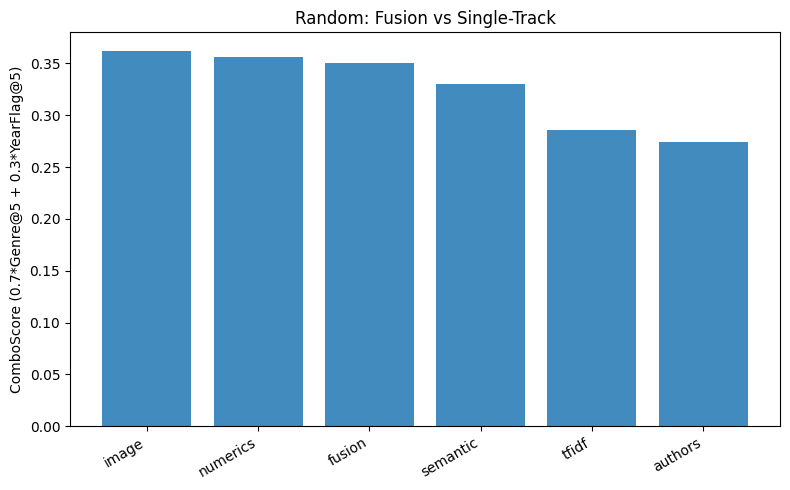

INFO:src.recsys.fusion:renorm_weights initial={'tfidf': 0.30612244897959184, 'semantic': 0.40816326530612246, 'authors': 0.10204081632653061, 'numerics': 0.15306122448979592, 'image': 0.030612244897959183} available=['tfidf', 'semantic', 'authors', 'numerics', 'image']
INFO:src.recsys.fusion:renorm_weights final={'tfidf': 0.30612244897959184, 'semantic': 0.40816326530612246, 'authors': 0.10204081632653061, 'numerics': 0.15306122448979592, 'image': 0.030612244897959183}
INFO:src.recsys.fusion:renorm_weights initial={'tfidf': 0.30612244897959184, 'semantic': 0.40816326530612246, 'authors': 0.10204081632653061, 'numerics': 0.15306122448979592, 'image': 0.030612244897959183} available=['tfidf', 'semantic', 'authors', 'numerics', 'image']
INFO:src.recsys.fusion:renorm_weights final={'tfidf': 0.30612244897959184, 'semantic': 0.40816326530612246, 'authors': 0.10204081632653061, 'numerics': 0.15306122448979592, 'image': 0.030612244897959183}
INFO:src.recsys.fusion:blend_ranked mods=['tfidf', '


=== Outliers (subset) ===


INFO:src.recsys.fusion:mmr_rerank_generic k=5 lam=0.950 picked=[15, 445, 1331, 1803, 1181]
INFO:src.recsys.fusion:renorm_weights initial={'tfidf': 0.30612244897959184, 'semantic': 0.40816326530612246, 'authors': 0.10204081632653061, 'numerics': 0.15306122448979592, 'image': 0.030612244897959183} available=['tfidf', 'semantic', 'authors', 'numerics', 'image']
INFO:src.recsys.fusion:renorm_weights final={'tfidf': 0.30612244897959184, 'semantic': 0.40816326530612246, 'authors': 0.10204081632653061, 'numerics': 0.15306122448979592, 'image': 0.030612244897959183}
INFO:src.recsys.fusion:blend_ranked mods=['tfidf', 'semantic', 'authors', 'numerics', 'image'] n=4765
INFO:src.recsys.fusion:mmr_rerank_generic k=5 lam=0.950 picked=[18, 20, 19, 16, 22]
INFO:src.recsys.fusion:renorm_weights initial={'tfidf': 0.30612244897959184, 'semantic': 0.40816326530612246, 'authors': 0.10204081632653061, 'numerics': 0.15306122448979592} available=['tfidf', 'semantic', 'authors', 'numerics']
INFO:src.recsys.fus

,model,n,Genre@K_mean,YearFlag@K_mean,ComboScore_mean
0,fusion,4,0.287857,0.783333,0.436500
1,tfidf,4,0.238968,0.633333,0.357278
4,numerics,4,0.071429,1.000000,0.350000
3,authors,4,0.071429,0.783333,0.285000
5,image,4,0.194048,0.450000,0.270833
2,semantic,4,0.071429,0.700000,0.260000


🏆 Outliers: Winner = fusion | Combo=0.4365 | Genre@K=0.2879 | YearFlag@K=0.7833


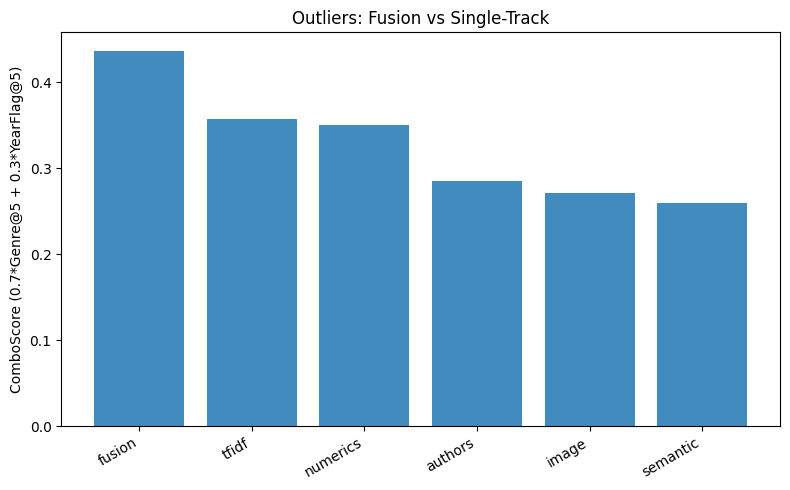

In [7]:
modalities = list(weights.keys())

onehots = {m: build_onehot_weights(modalities, m) for m in modalities}

out_sample = outliers[: min(5, len(outliers))]

def compare_group(seed_list, group_name):
    summaries = []

    _, sum_fusion = eval_weights_on_seeds(seed_list, weights, label="fusion", k=K)
    summaries.append(sum_fusion)

    for m, w in onehots.items():
        _, s = eval_weights_on_seeds(seed_list, w, label=m, k=K)
        summaries.append(s)

    res = pd.DataFrame(summaries).sort_values("ComboScore_mean", ascending=False)
    display(res)

    winner = res.iloc[0]
    print(f"🏆 {group_name}: Winner = {winner['model']} | Combo={winner['ComboScore_mean']:.4f} | Genre@K={winner['Genre@K_mean']:.4f} | YearFlag@K={winner['YearFlag@K_mean']:.4f}")

    plt.figure()
    plt.bar(res["model"], res["ComboScore_mean"], alpha=0.85)
    plt.xticks(rotation=30, ha="right")
    plt.ylabel(f"ComboScore (0.7*Genre@{K} + 0.3*YearFlag@{K})")
    plt.title(f"{group_name}: Fusion vs Single-Track")
    plt.tight_layout()
    plt.show()

    return res

print("=== Random (5 seeds) ===")
res_random = compare_group(rand_idxs, "Random")

print("\n=== Outliers (subset) ===")
res_out = compare_group(out_sample, "Outliers")


### Per-Seed Winners (who beats whom?)
For each seed, we compute the ComboScore for **Fusion** and **each single modality**, and mark the **winner**.  
This helps identify cases where a single track (e.g., semantic) outperforms the hybrid.


In [ ]:
def per_seed_winners(seed_list, k=K):
    rows = []
    for s in seed_list:
        df_f, _ = eval_weights_on_seeds([s], weights, "fusion", k=k)
        combo_f = float(df_f["ComboScore"].iloc[0])

        combos = {"fusion": combo_f}
        for m, w in onehots.items():
            df_m, _ = eval_weights_on_seeds([s], w, m, k=k)
            combos[m] = float(df_m["ComboScore"].iloc[0])

        best_model = max(combos.items(), key=lambda kv: kv[1])[0]
        row = {"seed_row": int(s), **{f"{k}_Combo": v for k, v in combos.items()}, "winner": best_model}
        rows.append(row)

    out = pd.DataFrame(rows)
    out["title"] = out["seed_row"].apply(lambda i: df_clean.loc[i, "title"])
    out["authors"] = out["seed_row"].apply(lambda i: df_clean.loc[i, "authors"] if "authors" in df_clean.columns else "")
    cols = ["seed_row", "title", "authors", "winner"] + [c for c in out.columns if c.endswith("_Combo")]
    out = out[cols]
    return out

print("=== Per-seed winners: Random ===")
w_random = per_seed_winners(rand_idxs, k=K)
display(w_random)

print("\n=== Per-seed winners: Outliers (subset) ===")
w_out = per_seed_winners(out_sample, k=K)
display(w_out)


INFO:src.recsys.fusion:renorm_weights initial={'tfidf': 0.30612244897959184, 'semantic': 0.40816326530612246, 'authors': 0.10204081632653061, 'numerics': 0.15306122448979592, 'image': 0.030612244897959183} available=['tfidf', 'semantic', 'authors', 'numerics', 'image']
INFO:src.recsys.fusion:renorm_weights final={'tfidf': 0.30612244897959184, 'semantic': 0.40816326530612246, 'authors': 0.10204081632653061, 'numerics': 0.15306122448979592, 'image': 0.030612244897959183}
INFO:src.recsys.fusion:renorm_weights initial={'tfidf': 0.30612244897959184, 'semantic': 0.40816326530612246, 'authors': 0.10204081632653061, 'numerics': 0.15306122448979592, 'image': 0.030612244897959183} available=['tfidf', 'semantic', 'authors', 'numerics', 'image']
INFO:src.recsys.fusion:renorm_weights final={'tfidf': 0.30612244897959184, 'semantic': 0.40816326530612246, 'authors': 0.10204081632653061, 'numerics': 0.15306122448979592, 'image': 0.030612244897959183}
INFO:src.recsys.fusion:blend_ranked mods=['tfidf', '

=== Per-seed winners: Random ===


INFO:src.recsys.fusion:mmr_rerank_generic k=5 lam=0.950 picked=[2886, 4357, 3842, 3080, 2455]
INFO:src.recsys.fusion:renorm_weights initial={'tfidf': 1.0, 'semantic': 0.0, 'authors': 0.0, 'numerics': 0.0, 'image': 0.0} available=['tfidf', 'semantic', 'authors', 'numerics', 'image']
INFO:src.recsys.fusion:renorm_weights final={'tfidf': 1.0, 'semantic': 0.0, 'authors': 0.0, 'numerics': 0.0, 'image': 0.0}
INFO:src.recsys.fusion:renorm_weights initial={'tfidf': 1.0, 'semantic': 0.0, 'authors': 0.0, 'numerics': 0.0, 'image': 0.0} available=['tfidf', 'semantic', 'authors', 'numerics', 'image']
INFO:src.recsys.fusion:renorm_weights final={'tfidf': 1.0, 'semantic': 0.0, 'authors': 0.0, 'numerics': 0.0, 'image': 0.0}
INFO:src.recsys.fusion:blend_ranked mods=['tfidf', 'semantic', 'authors', 'numerics', 'image'] n=4765
INFO:src.recsys.fusion:mmr_rerank_generic k=5 lam=0.950 picked=[1706, 1777, 2966, 3025, 1881]
INFO:src.recsys.fusion:renorm_weights initial={'tfidf': 0.0, 'semantic': 1.0, 'authors

### Takeaways
- If **Fusion** wins most seeds in both groups → good evidence hybrid > any single modality.
- If a **single modality** repeatedly beats Fusion (e.g., `semantic`) → consider adjusting weights or conditional weights by genre/year.
- If **Outliers** favor a different winner than **Random**, add a note in the report and consider per-cluster weights.


## Evaluate Random vs Outliers
Metrics computed with **serving knobs** (caps + MMR), **no year bias**:

INFO:src.recsys.fusion:renorm_weights initial={'tfidf': 0.30612244897959184, 'semantic': 0.40816326530612246, 'authors': 0.10204081632653061, 'numerics': 0.15306122448979592, 'image': 0.030612244897959183} available=['tfidf', 'semantic', 'authors', 'numerics', 'image']
INFO:src.recsys.fusion:renorm_weights final={'tfidf': 0.30612244897959184, 'semantic': 0.40816326530612246, 'authors': 0.10204081632653061, 'numerics': 0.15306122448979592, 'image': 0.030612244897959183}
INFO:src.recsys.fusion:blend_ranked mods=['tfidf', 'semantic', 'authors', 'numerics', 'image'] n=4765
INFO:src.recsys.fusion:mmr_rerank_generic k=5 lam=0.950 picked=[2886, 4357, 3842, 3080, 2455]
INFO:src.recsys.fusion:renorm_weights initial={'tfidf': 0.30612244897959184, 'semantic': 0.40816326530612246, 'authors': 0.10204081632653061, 'numerics': 0.15306122448979592, 'image': 0.030612244897959183} available=['tfidf', 'semantic', 'authors', 'numerics', 'image']
INFO:src.recsys.fusion:renorm_weights final={'tfidf': 0.3061

Random: Genre@5=0.0714 | YearFlag@5=1.0000 | n=5


INFO:src.recsys.fusion:mmr_rerank_generic k=5 lam=0.950 picked=[15, 445, 1331, 1803, 1181]
INFO:src.recsys.fusion:renorm_weights initial={'tfidf': 0.30612244897959184, 'semantic': 0.40816326530612246, 'authors': 0.10204081632653061, 'numerics': 0.15306122448979592, 'image': 0.030612244897959183} available=['tfidf', 'semantic', 'authors', 'numerics', 'image']
INFO:src.recsys.fusion:renorm_weights final={'tfidf': 0.30612244897959184, 'semantic': 0.40816326530612246, 'authors': 0.10204081632653061, 'numerics': 0.15306122448979592, 'image': 0.030612244897959183}
INFO:src.recsys.fusion:blend_ranked mods=['tfidf', 'semantic', 'authors', 'numerics', 'image'] n=4765
INFO:src.recsys.fusion:mmr_rerank_generic k=5 lam=0.950 picked=[18, 20, 19, 16, 22]
INFO:src.recsys.fusion:renorm_weights initial={'tfidf': 0.30612244897959184, 'semantic': 0.40816326530612246, 'authors': 0.10204081632653061, 'numerics': 0.15306122448979592} available=['tfidf', 'semantic', 'authors', 'numerics']
INFO:src.recsys.fus

Outliers: Genre@5=0.2879 | YearFlag@5=0.7833 | n=4


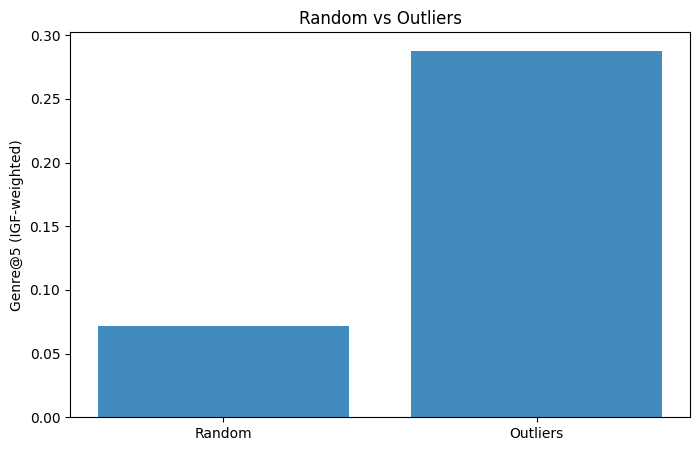

⚠️ Outliers perform significantly better than Random (2x). Consider adjusting weights or MMR settings and cheking genres as psudo lable.


In [ ]:
def eval_group(idxs, label, k=K):
    g_scores, y_scores = [], []
    for s in idxs:
        recs, _ = recommend_core(
            df_clean, reps, s, k=k, weights=weights,
            lam=MMR_LAMBDA, use_mmr=USE_MMR, mmr_space=MMR_SPACE,
            include_year_bias=False, year_bias_weight=0.0, year_tiebreak=False,
            caps=(AUTHOR_CAP[0], DESC_CAP[0]), image_min_coverage=IMAGE_MIN_COVERAGE
        )
        g = genre_at_k(s, recs, df_clean, genre_cache, igf=igf_combo, mode='combo') if genre_cache else np.nan
        y = yearflag_at_k(s, recs, df_clean, reps)
        g_scores.append(g); y_scores.append(y)
    g_mean = float(np.nanmean(g_scores)); y_mean = float(np.nanmean(y_scores))
    print(f"{label}: Genre@{k}={g_mean:.4f} | YearFlag@{k}={y_mean:.4f} | n={len(idxs)}")
    return g_mean, y_mean

g_rand, y_rand = eval_group(rand_idxs, 'Random')
g_out, y_out = eval_group(outliers, 'Outliers')

plt.bar(['Random','Outliers'], [g_rand, g_out], alpha=0.85)
plt.ylabel(f'Genre@{K} (IGF-weighted)')
plt.title('Random vs Outliers')
plt.show()

if not np.isnan(g_out) and g_out < 0.10:
    print('⚠️ Outliers underperform (<10%). Consider small weight tweaks or higher semantic emphasis for long-tail.')
elif g_out > g_rand*2:
    print('⚠️ Outliers perform significantly better than Random (2x). Consider adjusting weights or MMR settings and cheking genres as psudo lable.')
else:
    print('✅ Outlier performance is acceptable relative to Random.')

## Full results: 5 Random seeds and all Outliers
Rendered with **caps applied** and **MMR** as configured above.

In [ ]:
def render_group(idxs, label):
    print(f"\n## {label} seeds ({len(idxs)})")
    for s in idxs:
        _ = serve_explain_by_rowidx(s, topk=K)

render_group(rand_idxs, 'Random')
render_group(outliers, 'Outliers')

INFO:src.recsys.fusion:renorm_weights initial={'tfidf': 0.30612244897959184, 'semantic': 0.40816326530612246, 'authors': 0.10204081632653061, 'numerics': 0.15306122448979592, 'image': 0.030612244897959183} available=['tfidf', 'semantic', 'authors', 'numerics', 'image']
INFO:src.recsys.fusion:renorm_weights final={'tfidf': 0.30612244897959184, 'semantic': 0.40816326530612246, 'authors': 0.10204081632653061, 'numerics': 0.15306122448979592, 'image': 0.030612244897959183}
INFO:src.recsys.fusion:blend_ranked mods=['tfidf', 'semantic', 'authors', 'numerics', 'image'] n=4765



## Random seeds (5)


INFO:src.recsys.fusion:mmr_rerank_generic k=5 lam=0.950 picked=[2886, 4357, 3842, 3080, 2455]


rank,row_idx,book_id,title,authors,cover,fused_sum,tfidf_norm,semantic_norm,authors_norm,numerics_norm,image_norm
1,2886,6530,"Trace (Kay Scarpetta, #13)",Patricia Cornwell,,0.996894,0.305673,0.407478,0.101955,0.151616,0.030172
2,4357,20768868,"Flesh and Blood (Kay Scarpetta, #22)",Patricia Cornwell,,0.994998,0.305030,0.407649,0.101848,0.153029,0.027441
3,3842,7926242,"Port Mortuary (Kay Scarpetta, #18)",Patricia Cornwell,,0.966325,0.305416,0.407992,0.101784,0.151134,0.000000


INFO:src.recsys.fusion:renorm_weights initial={'tfidf': 0.30612244897959184, 'semantic': 0.40816326530612246, 'authors': 0.10204081632653061, 'numerics': 0.15306122448979592, 'image': 0.030612244897959183} available=['tfidf', 'semantic', 'authors', 'numerics', 'image']
INFO:src.recsys.fusion:renorm_weights final={'tfidf': 0.30612244897959184, 'semantic': 0.40816326530612246, 'authors': 0.10204081632653061, 'numerics': 0.15306122448979592, 'image': 0.030612244897959183}
INFO:src.recsys.fusion:blend_ranked mods=['tfidf', 'semantic', 'authors', 'numerics', 'image'] n=4765
INFO:src.recsys.fusion:mmr_rerank_generic k=5 lam=0.950 picked=[1398, 3655, 4037, 2450, 1615]


rank,row_idx,book_id,title,authors,cover,fused_sum,tfidf_norm,semantic_norm,authors_norm,numerics_norm,image_norm
1,1398,8680278,"We'll Always Have Summer (Summer, #3)",Jenny Han,,0.983733,0.304388,0.406878,0.089834,0.152451,0.030181
2,3655,15828714,"Sometimes It Lasts (Sea Breeze, #5)",Abbi Glines,,0.970980,0.306058,0.408078,0.101655,0.152997,0.002192
3,4037,18870159,"Bad for You (Sea Breeze, #7)",Abbi Glines,,0.942880,0.305801,0.407478,0.101870,0.104943,0.022789
4,2450,15778138,"Just for Now (Sea Breeze, #4)",Abbi Glines,,0.932330,0.305930,0.393858,0.101698,0.113615,0.017228
5,1615,7137775,"Rules of Attraction (Perfect Chemistry, #2)",Simone Elkeles,,0.927106,0.258453,0.399597,0.100927,0.152804,0.015324


INFO:src.recsys.fusion:renorm_weights initial={'tfidf': 0.30612244897959184, 'semantic': 0.40816326530612246, 'authors': 0.10204081632653061, 'numerics': 0.15306122448979592} available=['tfidf', 'semantic', 'authors', 'numerics']
INFO:src.recsys.fusion:renorm_weights final={'tfidf': 0.3157894736842105, 'semantic': 0.42105263157894735, 'authors': 0.10526315789473684, 'numerics': 0.15789473684210525}
INFO:src.recsys.fusion:blend_ranked mods=['tfidf', 'semantic', 'authors', 'numerics'] n=4765
INFO:src.recsys.fusion:mmr_rerank_generic k=5 lam=0.950 picked=[1044, 3106, 3036, 2452, 2774]


rank,row_idx,book_id,title,authors,cover,fused_sum,tfidf_norm,semantic_norm,authors_norm,numerics_norm
1,1044,156534,"Y: The Last Man, Vol. 1: Unmanned","Brian K. Vaughan, Pia Guerra, José Marzán Jr.",,0.968810,0.305801,0.407992,0.102019,0.152997
2,3106,156532,"Y: The Last Man, Vol. 9: Motherland (Y: The Last Man, #9)","Brian K. Vaughan, Pia Guerra, Goran Sudžuka, José Marzán Jr.",,0.967546,0.306058,0.408078,0.101955,0.151455
3,3036,79426,"Y: The Last Man, Vol. 7: Paper Dolls (Y: The Last Man, #7)","Brian K. Vaughan, Pia Guerra, Goran Sudžuka, José Marzán Jr.",,0.962792,0.305865,0.407564,0.101891,0.147472


INFO:src.recsys.fusion:renorm_weights initial={'tfidf': 0.30612244897959184, 'semantic': 0.40816326530612246, 'authors': 0.10204081632653061, 'numerics': 0.15306122448979592, 'image': 0.030612244897959183} available=['tfidf', 'semantic', 'authors', 'numerics', 'image']
INFO:src.recsys.fusion:renorm_weights final={'tfidf': 0.30612244897959184, 'semantic': 0.40816326530612246, 'authors': 0.10204081632653061, 'numerics': 0.15306122448979592, 'image': 0.030612244897959183}
INFO:src.recsys.fusion:blend_ranked mods=['tfidf', 'semantic', 'authors', 'numerics', 'image'] n=4765
INFO:src.recsys.fusion:mmr_rerank_generic k=5 lam=0.950 picked=[2230, 3693, 3322, 2281, 1281]


rank,row_idx,book_id,title,authors,cover,fused_sum,tfidf_norm,semantic_norm,authors_norm,numerics_norm,image_norm
1,2230,3467,"The People of Sparks (Book of Ember, #2)",Jeanne DuPrau,,0.960453,0.306058,0.407992,0.102019,0.140791,0.003593
2,3693,2493973,"The Diamond of Darkhold (Book of Ember, #4)",Jeanne DuPrau,,0.939719,0.305994,0.408078,0.101977,0.093122,0.030549
3,3322,207034,"The Prophet of Yonwood (Book of Ember, #3)",Jeanne DuPrau,,0.904360,0.305865,0.407906,0.101998,0.065272,0.023318
4,2281,2299110,Acheron (Dark-Hunter #14),Sherrilyn Kenyon,,0.948493,0.302589,0.406707,0.083003,0.128456,0.027738
5,1281,20560137,"An Ember in the Ashes (An Ember in the Ashes, #1)",Sabaa Tahir,,0.943527,0.305095,0.407821,0.094845,0.113005,0.022762


INFO:src.recsys.fusion:renorm_weights initial={'tfidf': 0.30612244897959184, 'semantic': 0.40816326530612246, 'authors': 0.10204081632653061, 'numerics': 0.15306122448979592} available=['tfidf', 'semantic', 'authors', 'numerics']
INFO:src.recsys.fusion:renorm_weights final={'tfidf': 0.3157894736842105, 'semantic': 0.42105263157894735, 'authors': 0.10526315789473684, 'numerics': 0.15789473684210525}
INFO:src.recsys.fusion:blend_ranked mods=['tfidf', 'semantic', 'authors', 'numerics'] n=4765
INFO:src.recsys.fusion:mmr_rerank_generic k=5 lam=0.950 picked=[1527, 2873, 2356, 1642, 1539]


rank,row_idx,book_id,title,authors,cover,fused_sum,tfidf_norm,semantic_norm,authors_norm,numerics_norm
1,1527,8705784,"Born at Midnight (Shadow Falls, #1)",C.C. Hunter,,0.961861,0.306058,0.408078,0.102019,0.145705
2,2873,13416236,"Whispers at Moonrise (Shadow Falls, #4)",C.C. Hunter,,0.960875,0.305930,0.407906,0.101977,0.145063
3,2356,12866426,"Taken at Dusk (Shadow Falls, #3)",C.C. Hunter,,0.953659,0.305994,0.407992,0.101998,0.137675
4,1642,2702704,"Faefever (Fever, #3)",Karen Marie Moning,,0.947459,0.294816,0.403538,0.096687,0.152419
5,1539,8428064,"Demonglass (Hex Hall, #2)",Rachel Hawkins,,0.945446,0.305352,0.403366,0.098893,0.137835


INFO:src.recsys.fusion:renorm_weights initial={'tfidf': 0.30612244897959184, 'semantic': 0.40816326530612246, 'authors': 0.10204081632653061, 'numerics': 0.15306122448979592, 'image': 0.030612244897959183} available=['tfidf', 'semantic', 'authors', 'numerics', 'image']
INFO:src.recsys.fusion:renorm_weights final={'tfidf': 0.30612244897959184, 'semantic': 0.40816326530612246, 'authors': 0.10204081632653061, 'numerics': 0.15306122448979592, 'image': 0.030612244897959183}
INFO:src.recsys.fusion:blend_ranked mods=['tfidf', 'semantic', 'authors', 'numerics', 'image'] n=4765



## Outliers seeds (4)


INFO:src.recsys.fusion:mmr_rerank_generic k=5 lam=0.950 picked=[15, 445, 1331, 1803, 1181]


rank,row_idx,book_id,title,authors,cover,fused_sum,tfidf_norm,semantic_norm,authors_norm,numerics_norm,image_norm
1,15,7260188,"Mockingjay (The Hunger Games, #3)",Suzanne Collins,,0.990531,0.305930,0.407992,0.101934,0.147504,0.027172
2,445,7938275,"The Hunger Games Trilogy Boxset (The Hunger Games, #1-3)",Suzanne Collins,,0.958298,0.306058,0.408078,0.101977,0.111592,0.030594
3,1331,262430,"Gregor the Overlander (Underland Chronicles, #1)",Suzanne Collins,,0.933240,0.302075,0.407478,0.101912,0.121774,0.000000
4,1803,7182899,"Into the Gauntlet (The 39 Clues, #10)",Margaret Peterson Haddix,,0.951090,0.294880,0.405508,0.080626,0.142589,0.027486
5,1181,13027304,The Hunger Games Tribute Guide,Emily Seife,,0.948544,0.305994,0.407821,0.059554,0.151551,0.023624


INFO:src.recsys.fusion:renorm_weights initial={'tfidf': 0.30612244897959184, 'semantic': 0.40816326530612246, 'authors': 0.10204081632653061, 'numerics': 0.15306122448979592, 'image': 0.030612244897959183} available=['tfidf', 'semantic', 'authors', 'numerics', 'image']
INFO:src.recsys.fusion:renorm_weights final={'tfidf': 0.30612244897959184, 'semantic': 0.40816326530612246, 'authors': 0.10204081632653061, 'numerics': 0.15306122448979592, 'image': 0.030612244897959183}
INFO:src.recsys.fusion:blend_ranked mods=['tfidf', 'semantic', 'authors', 'numerics', 'image'] n=4765
INFO:src.recsys.fusion:mmr_rerank_generic k=5 lam=0.950 picked=[18, 371, 1743, 1457, 1632]


rank,row_idx,book_id,title,authors,cover,fused_sum,tfidf_norm,semantic_norm,authors_norm,numerics_norm,image_norm
1,18,15881,"Harry Potter and the Chamber of Secrets (Harry Potter, #2)","J.K. Rowling, Mary GrandPré",,0.985643,0.305352,0.406193,0.101891,0.141658,0.030549
2,371,862041,"Harry Potter Boxset (Harry Potter, #1-7)",J.K. Rowling,,0.972513,0.306058,0.407478,0.101848,0.129355,0.027774
3,1743,99298,"The Harry Potter Collection 1-4 (Harry Potter, #1-4)","J.K. Rowling, Mary GrandPré",,0.952117,0.305287,0.396000,0.101977,0.148853,0.000000
4,1457,189802,Belgarath the Sorcerer,"David Eddings, Leigh Eddings",,0.980966,0.304324,0.405251,0.092169,0.150748,0.028474
5,1632,645023,"Castle of Wizardry (The Belgariad, #4)",David Eddings,,0.947630,0.293338,0.403024,0.101056,0.120490,0.029723


INFO:src.recsys.fusion:renorm_weights initial={'tfidf': 0.30612244897959184, 'semantic': 0.40816326530612246, 'authors': 0.10204081632653061, 'numerics': 0.15306122448979592} available=['tfidf', 'semantic', 'authors', 'numerics']
INFO:src.recsys.fusion:renorm_weights final={'tfidf': 0.3157894736842105, 'semantic': 0.42105263157894735, 'authors': 0.10526315789473684, 'numerics': 0.15789473684210525}
INFO:src.recsys.fusion:blend_ranked mods=['tfidf', 'semantic', 'authors', 'numerics'] n=4765
INFO:src.recsys.fusion:mmr_rerank_generic k=5 lam=0.950 picked=[334, 1320, 3, 384, 1285]


rank,row_idx,book_id,title,authors,cover,fused_sum,tfidf_norm,semantic_norm,authors_norm,numerics_norm
1,334,16793,Stardust,Neil Gaiman,,0.938058,0.304709,0.405936,0.074866,0.152547
2,1320,164154,A Canticle for Leibowitz,Walter M. Miller Jr.,,0.913110,0.294623,0.381352,0.094417,0.142718
3,3,2657,To Kill a Mockingbird,Harper Lee,,0.911022,0.301368,0.398056,0.068013,0.143585
4,384,9777,The God of Small Things,Arundhati Roy,,0.910476,0.288841,0.401996,0.075829,0.143810
5,1285,775597,"Caps for Sale: A Tale of a Peddler, Some Monkeys and Their Monkey Business",Esphyr Slobodkina,,0.904309,0.304324,0.367133,0.095274,0.137578


INFO:src.recsys.fusion:renorm_weights initial={'tfidf': 0.30612244897959184, 'semantic': 0.40816326530612246, 'authors': 0.10204081632653061, 'numerics': 0.15306122448979592, 'image': 0.030612244897959183} available=['tfidf', 'semantic', 'authors', 'numerics', 'image']
INFO:src.recsys.fusion:renorm_weights final={'tfidf': 0.30612244897959184, 'semantic': 0.40816326530612246, 'authors': 0.10204081632653061, 'numerics': 0.15306122448979592, 'image': 0.030612244897959183}
INFO:src.recsys.fusion:blend_ranked mods=['tfidf', 'semantic', 'authors', 'numerics', 'image'] n=4765
INFO:src.recsys.fusion:mmr_rerank_generic k=5 lam=0.950 picked=[494, 4468, 2292, 851, 1755]


rank,row_idx,book_id,title,authors,cover,fused_sum,tfidf_norm,semantic_norm,authors_norm,numerics_norm,image_norm
1,494,7235533,"The Way of Kings (The Stormlight Archive, #1)",Brandon Sanderson,,0.989287,0.306058,0.407992,0.101891,0.144324,0.029022
2,2292,15704486,"Calamity (The Reckoners, #3)",Brandon Sanderson,,0.975647,0.305223,0.402938,0.101741,0.140630,0.025115
3,1755,15704459,"Firefight (The Reckoners, #2)",Brandon Sanderson,,0.971271,0.305352,0.407478,0.101998,0.126882,0.029561


## Fusion weights (for transparency)
Exact weights used to fuse **rank-normalized** modality scores (numbers on bars).

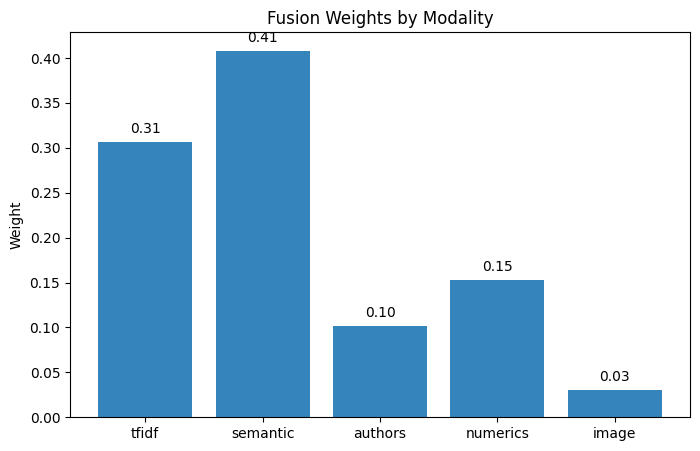

In [ ]:
plt.figure()
labs, vals = zip(*weights.items())
plt.bar(labs, vals, alpha=0.9)
for i,(k,v) in enumerate(weights.items()):
    plt.text(i, v+0.01, f"{v:.2f}", ha='center')
plt.title('Fusion Weights by Modality')
plt.ylabel('Weight')
plt.show()

## Interactive: exact title (lowercased)
Matches exactly after lowercase cleaning; returns top-5 with covers and normalized contributions.

In [ ]:
def query_book_exact(title_lc: str):
    t = str(title_lc or '').strip().lower()
    hits = df_clean.index[df_clean['title'].astype(str).str.lower()==t].tolist()
    if not hits:
        print('No exact lowercase match.')
        return
    return serve_explain_by_rowidx(hits[0], topk=K)

# Example:
_ = query_book_exact('the hobbit')

INFO:src.recsys.fusion:renorm_weights initial={'tfidf': 0.30612244897959184, 'semantic': 0.40816326530612246, 'authors': 0.10204081632653061, 'numerics': 0.15306122448979592, 'image': 0.030612244897959183} available=['tfidf', 'semantic', 'authors', 'numerics', 'image']
INFO:src.recsys.fusion:renorm_weights final={'tfidf': 0.30612244897959184, 'semantic': 0.40816326530612246, 'authors': 0.10204081632653061, 'numerics': 0.15306122448979592, 'image': 0.030612244897959183}
INFO:src.recsys.fusion:blend_ranked mods=['tfidf', 'semantic', 'authors', 'numerics', 'image'] n=4765
INFO:src.recsys.fusion:mmr_rerank_generic k=5 lam=0.950 picked=[166, 14, 846, 384, 332]


rank,row_idx,book_id,title,authors,cover,fused_sum,tfidf_norm,semantic_norm,authors_norm,numerics_norm,image_norm
1,166,33,"The Lord of the Rings (The Lord of the Rings, #1-3)",J.R.R. Tolkien,,0.993054,0.302589,0.407992,0.102019,0.152033,0.028421
2,14,34,"The Fellowship of the Ring (The Lord of the Rings, #1)",J.R.R. Tolkien,,0.970192,0.298413,0.405251,0.101998,0.152997,0.011533
3,846,30,J.R.R. Tolkien 4-Book Boxed Set: The Hobbit and The Lord of the Rings,J.R.R. Tolkien,,0.954113,0.305930,0.406022,0.101955,0.119044,0.021163
4,384,9777,The God of Small Things,Arundhati Roy,,0.944101,0.305737,0.388033,0.075808,0.144934,0.029588
5,332,1852,The Call of the Wild,Jack London,,0.936240,0.302910,0.404566,0.074523,0.146894,0.007348


## Save final metrics/config (for README & slides)

In [ ]:
MET_DIR = ART / 'metrics'
MET_DIR.mkdir(parents=True, exist_ok=True)
genre_sha = hashlib.sha1(json.dumps(genre_cache, sort_keys=True).encode('utf-8')).hexdigest()[:12] if genre_cache else 'none'
out = {
    'K': K, 'use_mmr': USE_MMR, 'mmr_space': MMR_SPACE, 'lambda': MMR_LAMBDA,
    'image_min_coverage': IMAGE_MIN_COVERAGE,
    'author_cap': AUTHOR_CAP, 'desc_cap': DESC_CAP,
    'weights': weights,
    'genre_cache_sha': genre_sha, 'coverage': float(coverage),
    'random': {'Genre@K': float(g_rand) if not np.isnan(g_rand) else None, 'YearFlag@K': float(y_rand)},
    'outliers': {'Genre@K': float(g_out) if not np.isnan(g_out) else None, 'YearFlag@K': float(y_out)}
}
with open(MET_DIR / 'final_results.json', 'w', encoding='utf-8') as f:
    json.dump(out, f, ensure_ascii=False, indent=2)
print('Saved →', MET_DIR / 'final_results.json')

Saved → c:\Users\User\Documents\book-recomendation\artifacts\metrics\final_results.json


## ✅ Wrap-up

- **Caps** and **MMR** used during serving
- **Per-modality normalized contributions** shown; fused sum is transparent
- **Random vs Outliers** evaluation and plot included
- **Interactive exact-title** cell for demo

If you later expose raw per-modality similarities from `recommend.py`, we can add a small cell to show **raw vs normalized** scores for each picked item — no duplicated logic needed.